In [1]:
import pandas as pd
import os
def load_rel():
    pmi_threshold = 1
    base_dir = '/home/lf/桌面/MIMIC全/mimic_tester/'
    
    rel_dir = os.path.join(base_dir,'../self_kg/')
    diag_proce_df = pd.read_csv(rel_dir+'diag_proce_rel.csv',sep='\t')
    diag_proce_df = diag_proce_df[diag_proce_df['pmi']>pmi_threshold]
    diag_pres_df = pd.read_csv(rel_dir+'diag_pres_rel.csv',sep='\t',dtype={'tail ent':str})
    diag_pres_df = diag_pres_df[diag_pres_df['pmi']>pmi_threshold]
    proce_pres_df = pd.read_csv(rel_dir+'proce_pres_rel.csv',sep='\t',dtype={'tail ent':str})
    proce_pres_df = proce_pres_df[proce_pres_df['pmi']>pmi_threshold]

    ndc2rxnorm_file = os.path.join(base_dir,'ndc_atc/ndc2rxnorm_mapping.txt')
    with open(ndc2rxnorm_file,'r') as f:
        ndc2rxnorm = eval(f.read())

    diag_proce_pairs = []
    diag_proce_df.apply(lambda row:diag_proce_pairs.append(str(row['head ent'])+'-'+str(row['tail ent'])),axis=1)

    diag_pres_pairs = []
    diag_pres_df.apply(lambda row:diag_pres_pairs.append(str(row['head ent'])+'-'+ndc2rxnorm[row['tail ent']]),axis=1)

    proce_pres_pairs = []
    proce_pres_df.apply(lambda row:proce_pres_pairs.append(str(row['head ent'])+'-'+ndc2rxnorm[row['tail ent']]),axis=1)
    
    return diag_proce_pairs,diag_pres_pairs,proce_pres_pairs
                     
    
REL_INFOS = load_rel()

print(len(REL_INFOS[0]))
print(len(REL_INFOS[1]))
print(len(REL_INFOS[2]))

49406
217088
69607


In [4]:
import pickle
# diag_input = open('../baselines/med2vec-master/diag.3digitICD9.seqs', 'rb')
diag_input = open('../baselines/med2vec-master/diag.types', 'rb')
print(len(pickle.load(diag_input)))

942


In [5]:
import pandas as pd
import numpy as np
from pylmnn import LargeMarginNearestNeighbor
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

train_file = '../self_dataset/train_admissions.csv'
test_file = '../self_dataset/test_admissions.csv'

# atherosclerosis 440;heart failure i50; chronic kidney n18; pneumonia 486;
# disease_cohorts = ['440','i50']
train_admission_df = pd.read_csv(train_file)
test_admission_df = pd.read_csv(test_file)
disease_cohorts = list(train_admission_df['disease'].value_counts().index.values[:6])
print(disease_cohorts)

# train_admission_df = train_admission_df[train_admission_df['disease'].isin(disease_cohorts)]
# print(len(train_admission_df))
# test_admission_df = test_admission_df[test_admission_df['disease'].isin(disease_cohorts)]
# print(len(test_admission_df))

# train_admission_df.to_csv('../large_cluster_dataset/train_admissions.csv',index=False)
# test_admission_df.to_csv('../large_cluster_dataset/test_admissions.csv',index=False)

['41401', 'V3001', '41071', 'V3000', '0389', '4241']


In [6]:
from sklearn.metrics.cluster import normalized_mutual_info_score
def purity(result, label):
    # 计算纯度
    total_num = len(label)
    cluster_counter = collections.Counter(result)
    original_counter = collections.Counter(label)
    t = []
    for k in cluster_counter:
        p_k = []
        for j in original_counter:
            count = 0
            for i in range(len(result)):
                if result[i] == k and label[i] == j: # 求交集
                    count += 1
            p_k.append(count)
        temp_t = max(p_k)
        t.append(temp_t)
    
    return sum(t)/total_num

def rand_index(result, label):
    
    total_num = len(label)
    
    TP = TN = FP = FN = 0
    for i in range(total_num):
        for j in range(i + 1, total_num):
            if label[i] == label[j] and result[i] == result[j]:
                TP += 1
            elif label[i] != label[j] and result[i] != result[j]:
                TN += 1
            elif label[i] != label[j] and result[i] == result[j]:
                FP += 1
            elif label[i] == label[j] and result[i] != result[j]:
                FN += 1
    
    return 1.0*(TP + TN)/(TP + FP + FN + TN)

In [9]:
from pylmnn import LargeMarginNearestNeighbor
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

import datetime

train_file = '../large_cluster_dataset/train_admissions.csv'
test_file = '../large_cluster_dataset/test_admissions.csv'

# atherosclerosis 440;heart failure i50; chronic kidney n18; pneumonia 486;
# disease_cohorts = ['440','i50']
train_admission_df = pd.read_csv(train_file)
test_admission_df = pd.read_csv(test_file)
disease_cohorts = list(set(train_admission_df['disease'].values))
print(disease_cohorts)

import collections

def construct_x_y(train_admission_df,test_admission_df,diseases):
    
    atc_codes, diag_codes, proce_codes = [], [], []
    train_admission_df['ATC'].apply(lambda x:atc_codes.extend(x.split(',')))
    train_admission_df['ICD9_DIAG'].apply(lambda x:diag_codes.extend(x.split(',')))
    train_admission_df['ICD9_PROCE'].apply(lambda x:proce_codes.extend(x.split(',')))
    test_admission_df['ATC'].apply(lambda x:atc_codes.extend(x.split(',')))
    test_admission_df['ICD9_DIAG'].apply(lambda x:diag_codes.extend(x.split(',')))
    test_admission_df['ICD9_PROCE'].apply(lambda x:proce_codes.extend(x.split(',')))
    
    
    atc_codes = list(set(atc_codes))
    diag_codes = list(set(diag_codes))
    proce_codes = list(set(proce_codes))
    medical_code_num = len(diag_codes)+len(proce_codes)+len(atc_codes)

    print(medical_code_num)
    
    res = []
    for admission_df in  [train_admission_df,test_admission_df]:
        cnt = 0
        admissions_reps, y = np.zeros((len(admission_df),medical_code_num)), []
        for idx,row in admission_df.iterrows():
            code_idxs = np.array([diag_codes.index(diag_code) for diag_code in row['ICD9_DIAG'].split(',')])
            code_idxs = np.concatenate((code_idxs, len(diag_codes)+np.array([proce_codes.index(proce_code) for proce_code in row['ICD9_PROCE'].split(',')])))
            code_idxs = np.concatenate((code_idxs, len(diag_codes)+len(proce_codes)+np.array([atc_codes.index(atc_code) for atc_code in row['ATC'].split(',')])))

            admissions_reps[cnt,code_idxs]=1
            cnt+=1

            y.append(diseases.index(row['disease']))
        res.append((admissions_reps, np.array(y)))
        
    return res

(train_x,train_y),(test_x, test_y) = construct_x_y(train_admission_df,test_admission_df,disease_cohorts)

print('data construct done')

print('Eudician KMeans result')
start= datetime.datetime.now()
neigh = KMeans(n_clusters=6,random_state=0)
result = neigh.fit_predict(test_x)
print((datetime.datetime.now()-start).total_seconds())
## onehot测试时间
print(len(result))
print(result)

def cal_metric(clusters,cohorts):
    me_purity = purity(clusters, cohorts)
    me_nmi = normalized_mutual_info_score(clusters, cohorts)
    me_ri = rand_index(clusters, cohorts)
    print('purity ',me_purity,' nmi ',me_nmi,' ri ',me_ri)
    
cal_metric(result,test_y)

['4019', 'V3001', 'V502', 'V3000', '2724', 'V290']
3959
data construct done
Eudician KMeans result
5.013238
2242
[0 5 0 ... 4 3 3]
purity  0.5196253345227475  nmi  0.36784968475145696  ri  0.7369726701433547


In [11]:
len(test_x)

1596

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_embedding(data, label, title):
    tsne = TSNE(n_components=2, init='pca', random_state=0)
    data, label = tsne.fit_transform(data), np.array(label)

#     x_min, x_max = np.min(data,0), np.max(data,0)
#     data = (data-x_min)/(x_max-x_min)
    
    fig = plt.figure()
    ax  = plt.subplot(111)
    
    plt.scatter(data[:,0],data[:,1],s=5,c=label*10)
        
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()

# plot_embedding(test_x,test_y,'label for onehot')
    

In [17]:
from metric_learn  import ITML_Supervised

print('itml with kmeans result')

itml = ITML_Supervised()
itml.fit(train_x,train_y)
print('training done')

test_predict = KMeans(n_clusters=6).fit_predict(itml.transform(test_x))
cal_metric(test_predict,test_y)

itml with kmeans result
training done
purity  0.6259398496240601  nmi  0.6852428880344636  ri  0.6600034569181574


In [56]:
print('LMNN with kmeans result')
#LMNN with KMeans
k=4
lmnn = LargeMarginNearestNeighbor(n_neighbors=k, random_state=100)
lmnn.fit(train_x,train_y)
print('training done')

test_predict = KMeans(n_clusters=6).fit_predict(lmnn.transform(test_x))
cal_metric(test_predict,test_y)

LMNN with kmeans result
training done
purity  0.9511278195488722  nmi  0.9002618395709596  ri  0.9624767247271785


nca with kmeans result
training done


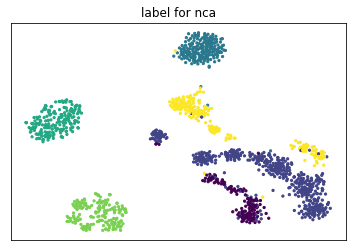

purity  0.7412280701754386  nmi  0.6848763875053965  ri  0.8520046196997195


In [56]:
print('nca with kmeans result')
from metric_learn import NCA
from sklearn.metrics.pairwise import euclidean_distances
nca = NCA()
nca.fit(train_x,train_y)
print('training done')

train_embs, test_embs = nca.transform(train_x), nca.transform(test_x)
plot_embedding(nca.transform(test_x),test_y,'label for nca')

test_predict = KMeans(n_clusters=6).fit_predict(nca.transform(test_x))
cal_metric(test_predict,test_y)

['4019', 'V3001', 'V502', 'V3000', '2724', 'V290']
## 预训练任务
1.52357
purity  0.4643175735950045  nmi  0.3628193460764309  ri  0.690499534066487
## 集群任务
2.615814
2242
0.0011667323818019624


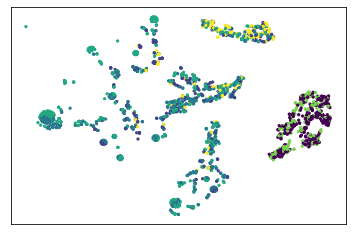

0.417418
0.00018618108831400536
{'accu': 0.1016949152542373, 'precision': 0.07578729994837378, 'recall': 0.17454543096516484, 'f1': 0.09958501867385085}
## 预测任务
0.437686
2242
0.00019522123104371097
purity  0.3809099018733274  nmi  0.1618101189685671  ri  0.6117521926341505
purity  0.44380017841213204  nmi  0.4009442914079812  ri  0.6613509245625578


In [13]:
#word2vec

import gensim
from gensim.models import Doc2Vec
from glove import Glove
from glove import Corpus
import pandas as pd
import numpy as np


from sklearn.manifold import TSNE
from sklearn.cluster import KMeans


def plot_embedding1(data, label, title):
    tsne = TSNE(n_components=2, init='pca', random_state=0)
    data, label = tsne.fit_transform(data), np.array(label)

#     x_min, x_max = np.min(data,0), np.max(data,0)
#     data = (data-x_min)/(x_max-x_min)
    
    fig = plt.figure()
    ax  = plt.subplot(111)
    
    plt.scatter(data[:,0],data[:,1],s=5,c=label*10)
        
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()
    plt.savefig("test.pdf")


train_file = '../large_cluster_dataset/train_admissions.csv'
test_file = '../large_cluster_dataset/test_admissions.csv'

# atherosclerosis 440;heart failure i50; chronic kidney n18; pneumonia 486;
# disease_cohorts = ['440','i50']
train_admission_df = pd.read_csv(train_file)
test_admission_df = pd.read_csv(test_file)
disease_cohorts = list(set(train_admission_df['disease'].values))
diseases = list(set(train_admission_df['disease'].values))
print(disease_cohorts)

diseases = list(set(train_admission_df['disease'].values))

def construct_corpus_y(train_admission_df):
    
    corpus, y = [], []
    train_admission_df['words'] = train_admission_df[['ATC','ICD9_DIAG','ICD9_PROCE']].apply(lambda x:' '.join(['a_'+atc_code for atc_code in x['ATC'].split(',')])+' '+\
                                                                                            ' '.join(['d_'+atc_code for atc_code in x['ICD9_DIAG'].split(',')])+' '+\
                                                                                                    ' '.join(['p_'+atc_code for atc_code in x['ICD9_PROCE'].split(',')]),axis=1) 
    for idx, row in train_admission_df.iterrows():
        corpus.append(row['words'])
        y.append(diseases.index(row['disease']))
    return corpus,y

train_corpus,train_y = construct_corpus_y(train_admission_df)
test_corpus, test_y = construct_corpus_y(test_admission_df)
# test_start = len(train_corpus)
# train_corpus.extend(test_corpus)

# from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer = TfidfVectorizer()
# x = vectorizer.fit_transform(test_corpus)

# test_predict = KMeans(n_clusters=6).fit_predict(x)
# cal_metric(test_predict,test_y)

test_start_idx = len(train_corpus)
train_corpus.extend(test_corpus)

def parse_corpus(test_corpus):
    ## 
    corpus_model = Corpus()
    corpus_model.fit([line.split() for line in train_corpus])
    glove = Glove()
    glove.fit(corpus_model.matrix)
    glove.add_dictionary(corpus_model.dictionary)
    test_x = []
    for line in test_corpus:
        test_x.append(np.mean([glove.word_vectors[glove.dictionary[word]] for word in line.split()], axis = 0))
    test_x = np.array(test_x)
    return test_x

import gensim
from gensim.models import Doc2Vec, Word2Vec
from glove import Glove
from glove import Corpus

import datetime

# corpus_model = Corpus()
# corpus_model.fit([line.split() for line in train_corpus])
# glove = Glove()
# glove.fit(corpus_model.matrix)
# glove.add_dictionary(corpus_model.dictionary)

# print('glove result')
# test_predict = KMeans(n_clusters=6).fit_predict(test_x)
# cal_metric(test_predict, test_y)

# test_x, train_x = parse_corpus(test_corpus), parse_corpus(train_corpus[:test_start_idx])
# plot_embedding(test_x, test_y,'')

# get_top_k_results(test_x,train_x)

## word2vec模型
start = datetime.datetime.now()
model = Word2Vec([line.split() for line in train_corpus], min_count=1)
end = datetime.datetime.now()
print('## 预训练任务')
print((end-start).total_seconds())

test_x = []
## 集群任务
start = datetime.datetime.now()
for line in test_corpus:
    test_x.append(np.mean([model.wv[word] for word in line.split()], axis=0))
test_x = np.array(test_x)

test_predict = KMeans(n_clusters=6).fit_predict(test_x)
cal_metric(test_predict, test_y)
end = datetime.datetime.now()
print('## 集群任务')
print((end-start).total_seconds())
print(len(test_y))
print(((end-start).total_seconds())/len(test_y))


test_x, train_x = parse_corpus(test_corpus), parse_corpus(train_corpus[:test_start_idx])
plot_embedding(test_x, test_y, '')

## 预测任务
start = datetime.datetime.now()
get_top_k_results(test_x,train_x,train_y,test_y)
end = datetime.datetime.now()
print('## 预测任务')
print((end-start).total_seconds())
print(len(test_y))
print(((end-start).total_seconds())/len(test_y))

count, documents = 0, []
for line in train_corpus:
    documents.append(gensim.models.doc2vec.TaggedDocument(line.split(),[str(count)]))
    count += 1
    
model = Doc2Vec(documents)
test_x = []
for _ in range(len(test_corpus)):
    test_x.append(model.docvecs[str(test_start_idx)])
    test_start_idx += 1
test_x = np.array(test_x)

test_predict = KMeans(n_clusters=6).fit_predict(test_x)
cal_metric(test_predict, test_y)

train_corpus.extend(test_corpus)
train_path = 'fast_train_unsupervised.txt'#'fast_train.txt'
train_file = open(train_path,'w',encoding='utf-8')
for train_doc, label in zip(train_corpus, train_y):
    train_file.write(train_doc+'\n')  
    
import fasttext
model = fasttext.train_unsupervised(train_path)

test_x = []
for doc in test_corpus:
    test_x.append(np.mean([model[word] for word in doc.split()],axis=0))
test_x = np.array(test_x)

test_predict = KMeans(n_clusters=6).fit_predict(test_x)
cal_metric(test_predict, test_y)

In [7]:
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score
def report_metrics(true_labels,predict_labels):
    return {'accu':accuracy_score(true_labels,predict_labels),'precision':precision_score(true_labels,predict_labels, average='macro'),'recall':recall_score(true_labels,predict_labels, average='macro'),'f1':f1_score(true_labels,predict_labels, average='macro')}


# tmp = nca.transform(test_x)
# train_tmp = nca.transform(train_x)

from sklearn.metrics import pairwise_distances
def get_top_k_results(tmp,train_tmp, train_y, test_y):
    import datetime
    ## onehot测试时间
    start = datetime.datetime.now()
    top_train_idx = np.argpartition(pairwise_distances(tmp,train_tmp),7,axis=1)[:,:7]

    predict_labels  = []
    for train_idx in top_train_idx:
        candiates = [train_y[t_idx] for t_idx in train_idx]      
        p_label = max(candiates,key=candiates.count)
        predict_labels.append(p_label)
    
    end = (datetime.datetime.now()-start).total_seconds()
    print(end)
    print((end/len(test_y)))   

    print(report_metrics(test_y,predict_labels))

print('onehot with kmeans result ')
get_top_k_results(test_x,train_x,train_y,test_y)
# print('onehot nca with kmeans result')
# get_top_k_results(nca.transform(test_x),nca.transform(train_x))
# print('onehot lmnn with kmeans result')
# get_top_k_results(lmnn.transform(test_x),lmnn.transform(train_x))
# print('onehot itml with kmeans result')
# get_top_k_results(itml.transform(test_x),itml.transform(train_x))

onehot with kmeans result 


NameError: name 'train_x' is not defined

In [8]:
import pickle

print(list(set(test_admission_df['disease'].values)))
print(list(set(train_admission_df['disease'].values)))

# def cal_visis_reps(onehot)

# types_file = '../baselines/med2vec-master/all.types'
# code2id = pickle.load(open(types_file,'rb'))
# # print(code2id)
# test_x = []
# for idx, row in test_admission_df.iterrows():
#     codes = ['diag_'+convert_to_3digit_icd9(diag_code) for diag_code in row['ICD9_DIAG'].split(',')]
#     codes.extend(['proc_'+convert_to_3digit_icd9(diag_code) for diag_code in row['ICD9_DIAG'].split(',')])
#     onehot_reps = np.zeros()
#     for code in codes:
#         if code in code2id:ids.append(code2id[code])
#     test_x.append()

4750
['4241', '41401', '0389', 'V3001', 'V3000', '41071']
['4241', '41401', '0389', 'V3001', 'V3000', '41071']


In [63]:
import pandas as pd

    
procedure_file = '../PROCEDURES_ICD.csv'
prescriptions_file = '../PRESCRIPTIONS.csv'
diagnoses_file = '../DIAGNOSES_ICD.csv'

proce_df = pd.read_csv(procedure_file)
pres_df = pd.read_csv(prescriptions_file,dtype={'NDC':'category'})
diag_df = pd.read_csv(diagnoses_file)

pres_df.drop(index=pres_df[pres_df['NDC'] == '0'].index, axis=0, inplace=True)


pres_df['ATC'] = pres_df['NDC'].map(ndc_atc_dic)

proce_df['CODE'] = proce_df['ICD9_CODE'].apply(lambda x:'proc_'+str(x))
proce_df = proce_df[['SUBJECT_ID','HADM_ID','CODE']]

diag_df['CODE'] = diag_df['ICD9_CODE'].apply(lambda x:'diag_'+str(x))
diag_df = diag_df[['SUBJECT_ID','HADM_ID','CODE']]

pres_df['CODE'] = pres_df['ATC'].apply(lambda x:'pres_'+str(x))
pres_df = pres_df[['SUBJECT_ID','HADM_ID','CODE']]

all_df = pd.concat([proce_df,diag_df,pres_df],axis=0,ignore_index=True)
all_df.to_csv('../all_seqs.csv',index=False)
# print(pres_df.columns)
# print(diag_df.columns)


dictionary done...


In [7]:
import pandas as pd
import numpy as np
import pickle
from sklearn.cluster import KMeans
import collections

ndc2rxnorm_file = 'ndc_atc/ndc2rxnorm_mapping.txt'
with open(ndc2rxnorm_file,'r') as f:
    ndc_atc_dic = eval(f.read())
print('dictionary done...')


def convert_to_3digit_icd9(dxStr):
	if dxStr.startswith('E'):
		if len(dxStr) > 4: return dxStr[:4]
		else: return dxStr
	else:
		if len(dxStr) > 3: return dxStr[:3]
		else: return dxStr

train_admission_df = pd.read_csv('../large_cluster_dataset/train_admissions.csv')
test_admission_df = pd.read_csv('../large_cluster_dataset/test_admissions.csv')
diseases = list(set(train_admission_df['disease'].values))


def ndc_to_atc(ndcstr):
    ndc_ls = []
    for ndc in ndcstr.split(','):
        if ndc in ndc_atc_dic:
            ndc_ls.append(ndc_atc_dic[ndc])
    return ','.join(ndc_ls)

def parse_x(train_admission_df,typ='diag'):
    train_admission_df['ATC_CODE'] = train_admission_df['NDC'].apply(ndc_to_atc)

    code_file = '../baselines/med2vec-master/'+typ+'.types'
    code2id = pickle.load(open(code_file,'rb'))
    code_nums = len(code2id)

    train_x,train_y = [], []
    for idx,row in train_admission_df.iterrows():
        if typ == 'diag':codes = ['diag_'+convert_to_3digit_icd9(code) for code in row['ICD9_DIAG'].split(',')]
        elif typ =='proc':codes = ['proc_'+code[:2] for code in row['ICD9_PROCE'].split(',')]
        elif typ == 'pres':codes = ['pres_'+code[:3] for code in row['ATC_CODE'].split(',')]
        code_idxs = [code2id[code] for code in codes]

        onehot_reps = np.zeros(code_nums)
        onehot_reps[code_idxs] = 1

        train_x.append(onehot_reps)

        train_y.append(diseases.index(row['disease']))
    return np.array(train_x), np.array(train_y)

diag_params_file = '../baselines/med2vec-master/diag.40.npz' #'../baselines/med2vec-master/diag.40.npz'#
diag_params = np.load(diag_params_file)

proc_params_file = '../baselines/med2vec-master/proc.40.npz' #'../baselines/med2vec-master/diag.40.npz'#
proc_params = np.load(proc_params_file)

pres_params_file = '../baselines/med2vec-master/pres.40.npz' #'../baselines/med2vec-master/diag.40.npz'#
pres_params = np.load(pres_params_file)

all_params_file = '../baselines/med2vec-master/all.20.npz'
all_params = np.load(all_params_file)

print(all_params['W_emb'].shape)

# pres_params_file = '../baselines/med2vec-master/pres.40.npz' #'../baselines/med2vec-master/diag.40.npz'#
# pres_params = np.load(pres_params_file)

# w_emb, b_emb, w_hidden, b_hidden = med2vec_params['W_emb'], med2vec_params['b_emb'], med2vec_params['W_hidden'], med2vec_params['b_hidden']
# code_cnt = w_emb.shape

"""def get_visis_reps(tparams,x):
    emb = np.maximum(x.dot(tparams['W_emb']) + tparams['b_emb'],0)
    visit = np.maximum(emb.dot(tparams['W_hidden']) + tparams['b_hidden'], 0)
    return visit
#     emb = T.maximum(T.dot(x, tparams['W_emb']) + tparams['b_emb'],0)
#     visit = T.maximum(T.dot(emb, tparams['W_hidden']) + tparams['b_hidden'],0)
#     return visit

diag_train_x, train_y = parse_x(train_admission_df,'diag')
diag_test_x, test_y = parse_x(test_admission_df,'diag')

proc_train_x, train_y = parse_x(train_admission_df,'proc')
proc_test_x, test_y = parse_x(test_admission_df,'proc')

pres_train_x, train_y = parse_x(train_admission_df,'pres')
pres_test_x, test_y = parse_x(test_admission_df,'pres')

all_train_x, train_y = parse_x(train_admission_df,'all')
all_test_x, test_y = parse_x(test_admission_df,'all')

diag_train_x = get_visis_reps(diag_params,diag_train_x)
diag_test_x = get_visis_reps(diag_params,diag_test_x)

proc_train_x = get_visis_reps(proc_params,proc_train_x)
proc_test_x = get_visis_reps(proc_params,proc_test_x)

pres_train_x = get_visis_reps(pres_params,pres_train_x)
pres_test_x = get_visis_reps(pres_params,pres_test_x)

all_train_x = get_visis_reps(all_params,all_train_x)
all_test_x = get_visis_reps(all_params,all_test_x)

# parsed_train_x = (diag_train_x+proc_train_x+pres_train_x)/3
# parsed_test_x = (diag_test_x+proc_test_x+pres_test_x)/3
parsed_train_x = all_train_x
parsed_test_x = all_test_x

def cal_metric(clusters,cohorts):
    me_purity = purity(clusters, cohorts)
    me_nmi = normalized_mutual_info_score(clusters, cohorts)
    me_ri = rand_index(clusters, cohorts)
    print('purity ',me_purity,' nmi ',me_nmi,' ri ',me_ri)

test_predict = KMeans(n_clusters=6).fit_predict(parsed_test_x)
cal_metric(test_predict,test_y)
plot_embedding(parsed_test_x,test_y,'')"""
# get_top_k_results(parsed_test_x,parsed_train_x, train_y, test_y)

dictionary done...
(1322, 100)


"def get_visis_reps(tparams,x):\n    emb = np.maximum(x.dot(tparams['W_emb']) + tparams['b_emb'],0)\n    visit = np.maximum(emb.dot(tparams['W_hidden']) + tparams['b_hidden'], 0)\n    return visit\n#     emb = T.maximum(T.dot(x, tparams['W_emb']) + tparams['b_emb'],0)\n#     visit = T.maximum(T.dot(emb, tparams['W_hidden']) + tparams['b_hidden'],0)\n#     return visit\n\ndiag_train_x, train_y = parse_x(train_admission_df,'diag')\ndiag_test_x, test_y = parse_x(test_admission_df,'diag')\n\nproc_train_x, train_y = parse_x(train_admission_df,'proc')\nproc_test_x, test_y = parse_x(test_admission_df,'proc')\n\npres_train_x, train_y = parse_x(train_admission_df,'pres')\npres_test_x, test_y = parse_x(test_admission_df,'pres')\n\nall_train_x, train_y = parse_x(train_admission_df,'all')\nall_test_x, test_y = parse_x(test_admission_df,'all')\n\ndiag_train_x = get_visis_reps(diag_params,diag_train_x)\ndiag_test_x = get_visis_reps(diag_params,diag_test_x)\n\nproc_train_x = get_visis_reps(proc_param

In [25]:
import pandas as pd
train_admission_df = pd.read_csv('../large_cluster_dataset/train_admissions.csv')
for idx, row in train_admission_df.iterrows():
    print(type(row['HADM_ID']))
    break
# test_admission_df = pd.read_csv('../large_cluster_dataset/test_admissions.csv')
# valid_admission_df = pd.read_csv('../large_cluster_dataset/valid_admissions.csv')

# print(len(train_admission_df), len(test_admission_df), len(valid_admission_df))

# all_df = pd.concat([train_admission_df, valid_admission_df, test_admission_df],axis=0)
# all_df.to_csv('../large_cluster_dataset/admissions.csv',index=False)
import tqdm
import csv
from tqdm import tqdm
f = open('../large_cluster_dataset/admissions.csv','r')
for line in tqdm(csv.DictReader(f)):
    encounter_id = line['HADM_ID']
    print(type(encounter_id))
    print(encounter_id)
    break

0it [00:00, ?it/s]

<class 'int'>
<class 'str'>
163353


In [76]:
print(test_admission_df)
print

0
hello
1
world
2
jack
0
(1, 'hello')
1
(2, 'world')
2
(3, 'jack')
